In [1]:
import xarray as xr 
import src as xc 
import matplotlib.pyplot as plt 
import pandas as pd 

bangladesh = xr.open_dataset('casestudy_data/ENACTS-BD-JJAS.nc').rfe_merged.expand_dims({'M':[0]})
global_nmme_jjas = xr.open_dataset('casestudy_data/GLOBAL_L1_JJAS.nc').prec

ohc = xc.RankedTerciles()
ohc.fit(bangladesh)
bangladesh_ohc = ohc.transform(bangladesh)

nmme_bd_jjas = global_nmme_jjas.where(global_nmme_jjas.X <= max(bangladesh.coords['X'].values), drop=True)
nmme_bd_jjas = nmme_bd_jjas.where(nmme_bd_jjas.X >= min(bangladesh.coords['X'].values), drop=True )
nmme_bd_jjas = nmme_bd_jjas.where(nmme_bd_jjas.Y >= min(bangladesh.coords['Y'].values), drop=True )
nmme_bd_jjas = nmme_bd_jjas.where(nmme_bd_jjas.Y <= max(bangladesh.coords['Y'].values), drop=True )
nmme_bd_jjas = xc.regrid(nmme_bd_jjas, bangladesh.coords['X'].values, bangladesh.coords['Y'].values)


In [2]:
poelm_xval = []
i=1

for x_train, y_train, x_test, y_test in xc.CrossValidator(nmme_bd_jjas, bangladesh.load(), window=1):
    start = pd.Timestamp.now()

    ohc = xc.RankedTerciles()
    ohc.fit(y_train)
    ohc_y_train = ohc.transform(y_train)
    
    poelm = xc.cPOELM(ND=3, hidden_layer_size=5, lat_chunks=1, lon_chunks=1, activation='relu')
    poelm.fit(x_train, ohc_y_train)
    poelm_preds = poelm.predict(x_test)
    poelm_xval.append(poelm_preds.isel(S=0))
    print('Fiting Window {}/37 - {}'.format(i, pd.Timestamp.now() - start), end='\r')
    i+= 1


poelm = xr.concat(poelm_xval, 'S')


In [5]:
groc = xc.GeneralizedROC(poelm.mean('ND'), bangladesh_ohc)
poelm_rps = xc.RankProbabilityScore(poelm.mean('ND'), bangladesh_ohc)
climatological_odds = xr.ones_like(poelm.mean('ND')) * 0.33 
climo_rps = xc.RankProbabilityScore(climatological_odds, bangladesh_ohc)
rpss = 1 - ( poelm_rps / climo_rps)

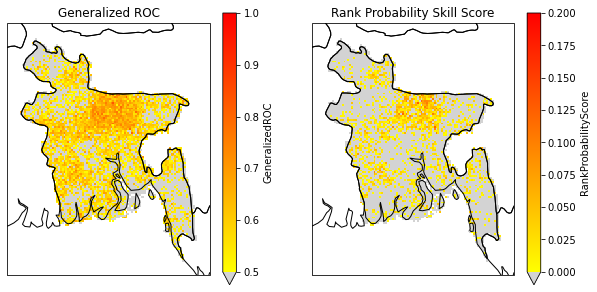

In [6]:
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature

cmap = plt.get_cmap('autumn_r')
cmap.set_under('lightgray')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
groc.plot(ax=ax[0], vmin=0.5, vmax=1, cmap=cmap)
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax[0].add_feature(states_provinces)
ax[0].set_title('Generalized ROC')

rpss.plot(ax=ax[1], vmin=0, vmax=0.2, cmap=cmap)
ax[1].add_feature(states_provinces)
ax[1].set_title('Rank Probability Skill Score')
plt.show()


In [ ]:
import numpy as np
#rpss = rpss.mean('M').mean('SKILLDIM')

xc.view_reliability(poelm.where(rpss > 0, other=np.nan) , bangladesh_ohc.where(rpss > 0, other=np.nan))

In [ ]:
xc.view_roc(poelm.where(rpss > 0, other=np.nan), bangladesh_ohc.where(rpss > 0, other=np.nan))

In [ ]:
poelm.to_netcdf('poelm_forecasts_bd_nd30_hl5_relu.nc')
bangladesh_ohc.to_netcdf('poelm_target_one_hot_encoded.nc')

In [ ]:
pbc = xc.PointBiserialCorrelation(poelm.isel(M=0).expand_dims({'M':[0]}) , bangladesh.isel(M=0).expand_dims({'M':[0]}))
